# Bank marketing

### Irving Gomez Mendez
### May 11, 2021

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox, chi2_contingency
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
def hist_variable(data, variable, binwidth=None):
    plt.figure(figsize=(10,7.5))
    sns.histplot(data=data, x=variable, stat='density', color='rebeccapurple')
    sns.kdeplot(data=data, x=variable, fill=True, color='rebeccapurple', linewidth=2)

In [4]:
dat = pd.read_csv("bank_additional/bank-additional.csv", sep=';')
dat = dat.rename(columns={'y':'deposit'})
dat = dat.astype({
    'job': 'category',
    'marital': 'category',
    'education': 'category',
    'default': 'category',
    'housing': 'category',
    'loan': 'category',
    'contact': 'category',
    'month': 'category',
    'day_of_week': 'category',
    'poutcome': 'category',
    'deposit': 'category'})

dat = dat[['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

In [5]:
# Brief description of the data
dat.describe()

,duration,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,256.788055,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,254.703736,1.563114,0.579349,4.594578,1.733591,73.667904
min,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,103.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,181.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,317.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,3643.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


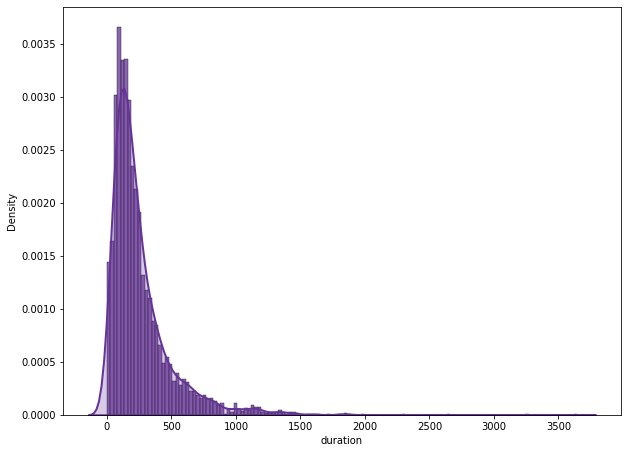

In [6]:
hist_variable(dat, 'duration')

In [7]:
dat = dat[dat['duration'] > 0]

In [8]:
# We can perform a Box-Cox transformation to normalize the duration?
duration_transform, lamb = boxcox(dat['duration'])

lamb

0.14373775316797655

<AxesSubplot:ylabel='Density'>

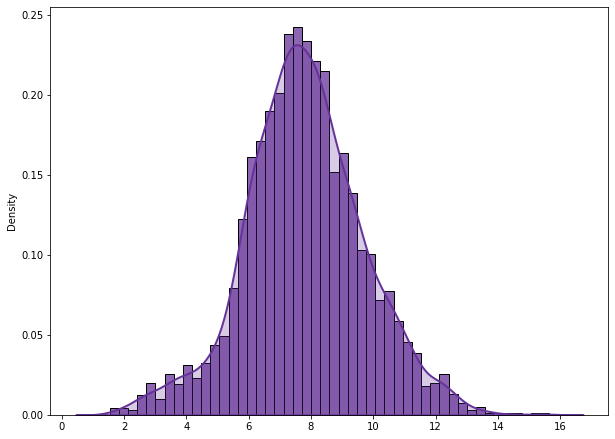

In [9]:
plt.figure(figsize=(10,7.5))
sns.histplot(duration_transform, stat='density', color='rebeccapurple')
sns.kdeplot(duration_transform, fill=True, color='rebeccapurple', linewidth=2)

In [10]:
np.mean(duration_transform)

7.786876062380533

In [11]:
np.std(duration_transform)

1.9060622062159207

In [12]:
(duration_transform*lamb+1)**(1/lamb)

array([487., 346., 227., ...,  64., 528., 175.])

In [13]:
dat['duration_transform'] = duration_transform

Social and economic data

In [14]:
dat_social_economic = dat[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
np.round(dat_social_economic.describe(),3)

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4118.000,4118.000,4118.000,4118.000,4118.000
mean,0.085,93.580,-40.500,3.621,5166.476
std,1.563,0.579,4.595,1.734,73.676
min,-3.400,92.201,-50.800,0.635,4963.600
25%,-1.800,93.075,-42.700,1.334,5099.100
50%,1.100,93.749,-41.800,4.857,5191.000
75%,1.400,93.994,-36.400,4.961,5228.100
max,1.400,94.767,-26.900,5.045,5228.100


In [15]:
# We check the condition number
np.linalg.cond(dat_social_economic)
# The condition number is too big, we can see that nr.employed has a different scale that the other features.
# It could be better to standardize this data

26088.67275429151

In [16]:
dat_social_economic_scale = StandardScaler().fit_transform(dat_social_economic)
dat_social_economic_scale = pd.DataFrame(dat_social_economic_scale, columns=dat_social_economic.columns)

np.linalg.cond(dat_social_economic_scale)
# The condition number is low now, but it could mean a moderate to high correlation between variables

# Kendall-Silvey suggestion as follows: there are as many near dependencies among the columns of a data matrix X as
# there are high condition indexes (singular values small relative to p,,). Two points regarding this extension must be emphasized.

# weak dependencies are associated with condition indexes around 5 or 10, whereas moderate to strong
# relations are associated with condition indexes of 30 to 100.

17.689800138608643

<AxesSubplot:>

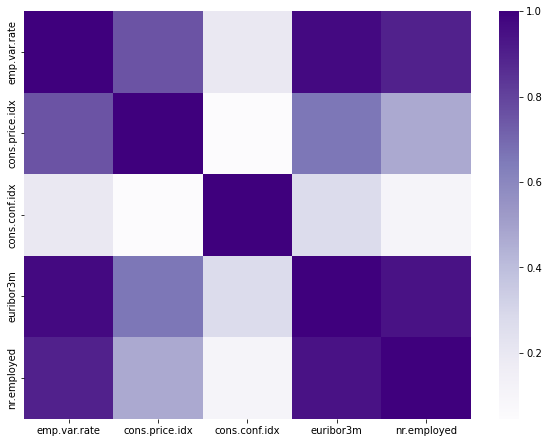

In [18]:
corr_matrix = dat_social_economic_scale.corr()

plt.figure(figsize=(10,7.5))
sns.heatmap(corr_matrix, cmap='Purples')
# It looks like 4 variables, except cons.conf.idx are highly correlated
# Especially euribor3m and nr.employed, we could just select one of these variables

In [19]:
corr_matrix

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.755127,0.194910,0.970305,0.897179
cons.price.idx,0.755127,1.000000,0.045687,0.657117,0.472538
cons.conf.idx,0.194910,0.045687,1.000000,0.276484,0.106994
euribor3m,0.970305,0.657117,0.276484,1.000000,0.942603
nr.employed,0.897179,0.472538,0.106994,0.942603,1.000000


In [20]:
# We calculate the Variance Inflation Factors

#One recommendation is that if VIF is greater than 5, then the explanatory
#variable given by exog_idx is highly collinear with the other explanatory
#variables, and the parameter estimates will have large standard errors
#because of this.

vif = pd.DataFrame()
vif["VIF Factor"] = np.round([variance_inflation_factor(dat_social_economic_scale.values, i) for i in range(dat_social_economic_scale.shape[1])],2)
vif["features"] = dat_social_economic_scale.columns
vif

,VIF Factor,features
0,31.68,emp.var.rate
1,6.29,cons.price.idx
2,2.49,cons.conf.idx
3,62.36,euribor3m
4,30.13,nr.employed


In [21]:
np.diag(np.linalg.inv(dat_social_economic_scale.T @ dat_social_economic_scale))*4119

array([31.68631844,  6.28819962,  2.48861078, 62.37406468, 30.13392871])

In [22]:
np.diag(np.linalg.inv(corr_matrix))

array([31.67862571,  6.28667299,  2.4880066 , 62.35892167, 30.12661288])

<Figure size 360x360 with 0 Axes>

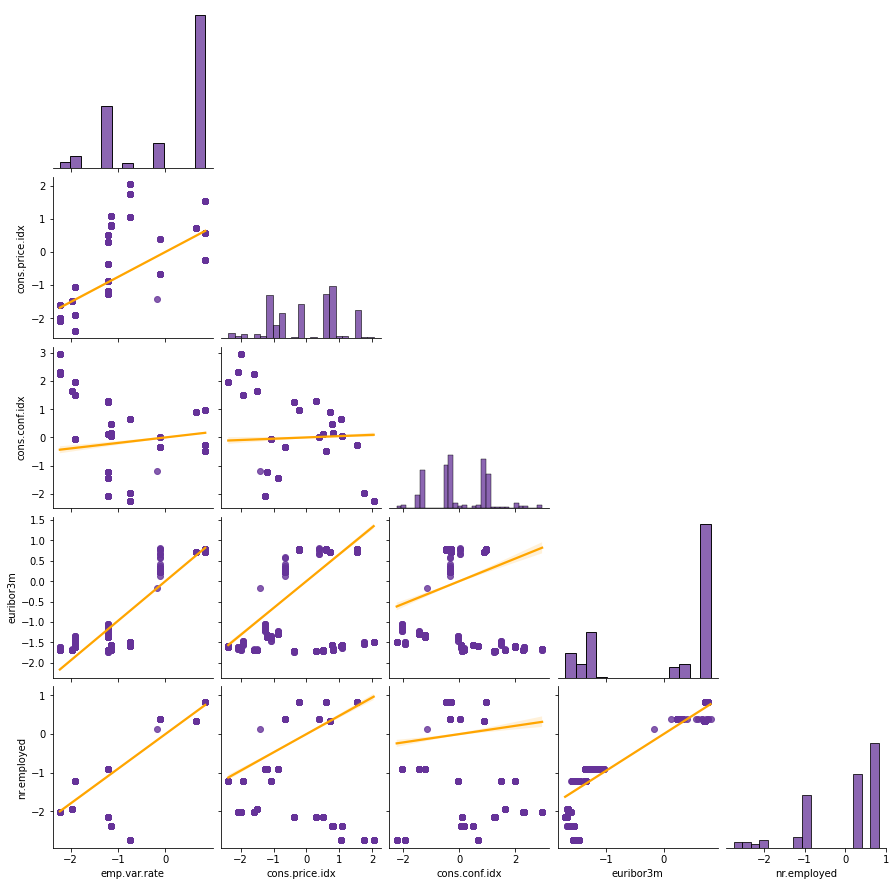

In [23]:
# Let's do the pairplot.
plt.figure(figsize=(5,5))
sns.pairplot(dat_social_economic_scale, kind="reg", corner = True,
    plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws':{'color': 'rebeccapurple'}},
    diag_kws={'color': 'rebeccapurple'})

In [25]:
# We can check all the condition indexes
u, d, vt = np.linalg.svd(dat_social_economic_scale)
v = vt.T

np.round(d[0]/d,2)

array([ 1.  ,  1.86,  2.48, 11.45, 17.69])

In [26]:
# There are two conditions indexes above 10, the rest are below 5. This would mean that there
# are 2 collinearities in the data
phis = v**2/d**2
var_decomp_portions = phis.T/sum(phis.T)

[Text(0.5, 0, 'emp.var.rate'),
 Text(1.5, 0, 'cons.price.idx'),
 Text(2.5, 0, 'cons.conf.idx'),
 Text(3.5, 0, 'euribor3m'),
 Text(4.5, 0, 'nr.employed')]

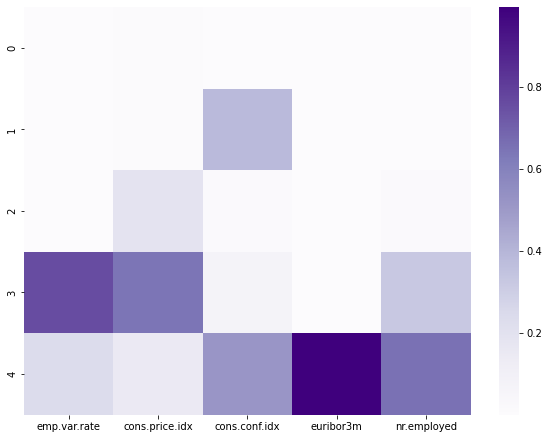

In [27]:
plt.figure(figsize=(10,7.5))
ax = sns.heatmap(var_decomp_portions, cmap='Purples')
ax.xaxis.set_ticklabels(dat_social_economic_scale.columns)
# This suggests a collinearity between the last 3 variables (especially the last 2)
# and another collinearity between the first two variables